## Chemprop can extrapolate to larger molecular weights given a change from the mean to the norm aggregation. Chemprop v2's atom featurizer also contains the mass of the atom as an initial feature; we can look at the impact of removing the molecular weight as well. It does not require the atom mass to predict molecular weight outside of its training label range. Using Chemprop 2.0.5 for the experiments.

In [27]:
import sys
import os
import pandas as pd
from lightning import pytorch as pl
from chemprop.chemprop import data, featurizers, models, nn
from chemprop.chemprop.nn import metrics
from chemprop.chemprop.models import MPNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem.rdchem import Atom
from typing import Sequence
import itertools
import warnings
import logging

## Creating a custom atom featurizer to keep/remove the atomic mass as an initial feature to compare performance with/without that information

In [14]:
class CustomMultiHotAtomFeaturizerAM(featurizers.MultiHotAtomFeaturizer):
    
    def __init__(
        self,
        atomic_nums: Sequence[int],
        degrees: Sequence[int],
        formal_charges: Sequence[int],
        chiral_tags: Sequence[int],
        num_Hs: Sequence[int],
        hybridizations: Sequence[int],
    ):
        super().__init__(
            atomic_nums,
            degrees,
            formal_charges,
            chiral_tags,
            num_Hs,
            hybridizations
        )
        
    def __call__(self, a: Atom | None) -> np.ndarray:
        x = np.zeros(self.__len__())

        if a is None:
            return x

        feats = [
            a.GetAtomicNum(),
            a.GetTotalDegree(),
            a.GetFormalCharge(),
            int(a.GetChiralTag()),
            int(a.GetTotalNumHs()),
            a.GetHybridization(),
        ]
        i = 0
        for feat, choices in zip(feats, self._subfeats):
            j = choices.get(feat, len(choices))
            x[i + j] = 1
            i += len(choices) + 1
        x[i] = int(a.GetIsAromatic())
        x[i + 1] = 0.01 * a.GetMass()

        return x
    

class CustomMultiHotAtomFeaturizerNoAM(featurizers.MultiHotAtomFeaturizer):
    
    def __init__(
        self,
        atomic_nums: Sequence[int],
        degrees: Sequence[int],
        formal_charges: Sequence[int],
        chiral_tags: Sequence[int],
        num_Hs: Sequence[int],
        hybridizations: Sequence[int],
    ):
        super().__init__(
            atomic_nums,
            degrees,
            formal_charges,
            chiral_tags,
            num_Hs,
            hybridizations
        )
        
    def __call__(self, a: Atom | None) -> np.ndarray:
        x = np.zeros(self.__len__())

        if a is None:
            return x

        feats = [
            a.GetAtomicNum(),
            a.GetTotalDegree(),
            a.GetFormalCharge(),
            int(a.GetChiralTag()),
            int(a.GetTotalNumHs()),
            a.GetHybridization(),
        ]
        i = 0
        for feat, choices in zip(feats, self._subfeats):
            j = choices.get(feat, len(choices))
            x[i + j] = 1
            i += len(choices) + 1
        x[i] = int(a.GetIsAromatic())
        #x[i + 1] = 0.01 * a.GetMass()

        return x

class CustomMultiHotAtomFeaturizerNoAMNoAtomNumber(featurizers.MultiHotAtomFeaturizer):
    
    def __init__(
        self,
        atomic_nums: Sequence[int],
        degrees: Sequence[int],
        formal_charges: Sequence[int],
        chiral_tags: Sequence[int],
        num_Hs: Sequence[int],
        hybridizations: Sequence[int],
    ):
        super().__init__(
            atomic_nums,
            degrees,
            formal_charges,
            chiral_tags,
            num_Hs,
            hybridizations
        )
        
    def __call__(self, a: Atom | None) -> np.ndarray:
        x = np.zeros(self.__len__())

        if a is None:
            return x

        feats = [
            0, #atomic number is hardcoded to 0
            a.GetTotalDegree(),
            a.GetFormalCharge(),
            int(a.GetChiralTag()),
            int(a.GetTotalNumHs()),
            a.GetHybridization(),
        ]
        i = 0
        for feat, choices in zip(feats, self._subfeats):
            j = choices.get(feat, len(choices))
            x[i + j] = 1
            i += len(choices) + 1
        x[i] = int(a.GetIsAromatic())
        #x[i + 1] = 0.01 * a.GetMass()

        return x


## Initializing the featurizers and check that the featurizer is what we expect

In [15]:
default_atom_featurizer = CustomMultiHotAtomFeaturizerAM.v2()
no_mw_atom_featurizer = CustomMultiHotAtomFeaturizerNoAM.v2()
no_mw_no_an_atom_featurizer = CustomMultiHotAtomFeaturizerNoAMNoAtomNumber.v2()

In [16]:
default_atom_featurizer(Chem.MolFromSmiles("CCC").GetAtoms()[0])

array([0.     , 0.     , 0.     , 0.     , 0.     , 1.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       1.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       1.     , 0.     , 1.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 1.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 1.     , 0.     , 0.     , 0.     ,
       0.     , 0.12011])

In [17]:
no_mw_atom_featurizer(Chem.MolFromSmiles("CCC").GetAtoms()[0])

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0.])

In [18]:
no_mw_no_an_atom_featurizer(Chem.MolFromSmiles("CCC").GetAtoms()[0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0.])

## Get the true values from the dataset

In [ ]:
df_test = df_test_out = pd.read_csv("test_mw_lt_400.csv")
test_smis = df_test.loc[:, "SMILES"].values
test_ys = df_test.loc[:, "mw"].values
test_ys = test_ys.reshape(-1, 1)


df_test_out = pd.read_csv("test_mw_gt_500.csv")
test_smis_out = df_test_out.loc[:, "SMILES"].values
test_ys_out = df_test_out.loc[:, "mw"].values
test_ys_out = test_ys_out.reshape(-1, 1)

## Chemprop script from ml_cant_extrapolate, with small changes for option handling and naming changes for Chemprop versions

In [32]:
def run_chemprop(
    train, 
    test, 
    y_col, 
    num_epochs=20, 
    accelerator="cpu", 
    atom_featurizer=default_atom_featurizer, 
    aggregation="mean"
):
    # Generate the validation set
    train, val = train_test_split(train, test_size=len(test))
    # Convert data to MoleculeDatapoints
    train_pt = [data.MoleculeDatapoint.from_smi(smi, [y]) for smi, y in train[["SMILES", y_col]].values]
    val_pt = [data.MoleculeDatapoint.from_smi(smi, [y]) for smi, y in val[["SMILES", y_col]].values]
    test_pt = [data.MoleculeDatapoint.from_smi(smi, [y]) for smi, y in test[["SMILES", y_col]].values]
    
    # Instantiate the featurizer with the atom_featurizer we want to use
    featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer(atom_featurizer=atom_featurizer)
    
    # Create datasets and scalers
    train_dset = data.MoleculeDataset(train_pt, featurizer)
    scaler = train_dset.normalize_targets()

    val_dset = data.MoleculeDataset(val_pt, featurizer)
    val_dset.normalize_targets(scaler)

    test_dset = data.MoleculeDataset(test_pt, featurizer)
    output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
    # Generate data loaders
    num_workers = 0
    train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
    val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
    test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)
    # Create the FFNN
    mp = nn.BondMessagePassing(d_e=featurizer.shape[1], d_v=featurizer.shape[0])
    
    if aggregation=="mean":
        agg = nn.MeanAggregation()
    else:
        agg = nn.NormAggregation()
    ffn_input_dim = mp.output_dim
    ffn = nn.RegressionFFN(input_dim=ffn_input_dim, output_transform=output_transform)
    # Create the MPNN
    batch_norm = True
    metric_list = [metrics.RMSEMetric()]
    mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)
    # Train the model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        trainer = pl.Trainer(
            logger=False,
            enable_checkpointing=False,
            enable_progress_bar=True,
            accelerator=accelerator,
            devices=1,
            max_epochs=num_epochs,  # number of epochs to train for
        )

        logging.disable(logging.CRITICAL)
            
        trainer.fit(mpnn, train_loader, val_loader)
        pred_tensor = trainer.predict(mpnn, test_loader)
        # Predict on the test set
        pred = np.array(list(itertools.chain(*pred_tensor))).flatten()

        logging.disable(logging.NOTSET)
        return pred

## Running with the same parameters from the initial notebook:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

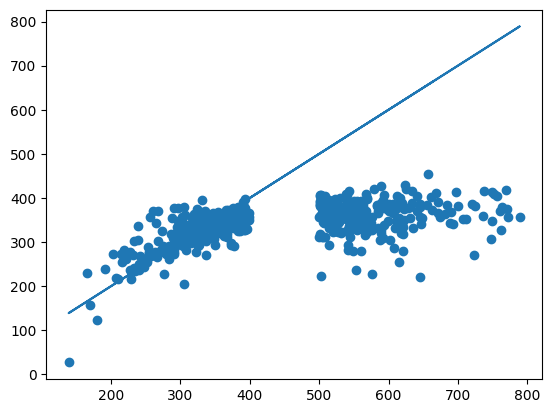

In [33]:
chemprop_pred_le_400 = run_chemprop(pd.read_csv("train_mw_lt_400.csv"), pd.read_csv("test_mw_lt_400.csv"), "mw", num_epochs=20)
chemprop_pred_gt_500 = run_chemprop(pd.read_csv("train_mw_lt_400.csv"), pd.read_csv("test_mw_gt_500.csv"), "mw", num_epochs=20)
plt.scatter(np.concatenate([test_ys, test_ys_out]), np.concatenate([chemprop_pred_le_400, chemprop_pred_gt_500]))
plt.plot(np.concatenate([test_ys, test_ys_out]), np.concatenate([test_ys, test_ys_out]))

## Running with norm aggregation

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

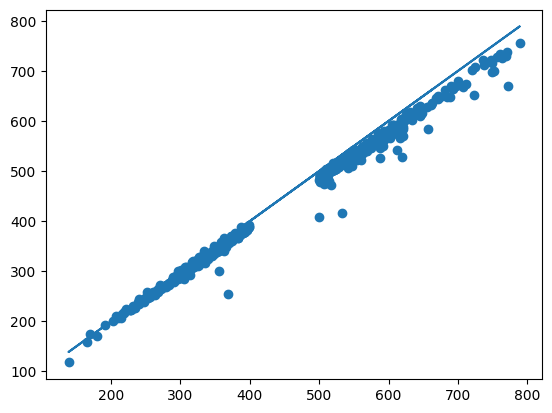

In [34]:
chemprop_pred_le_400 = run_chemprop(pd.read_csv("train_mw_lt_400.csv"), pd.read_csv("test_mw_lt_400.csv"), "mw", num_epochs=20, aggregation="norm")
chemprop_pred_gt_500 = run_chemprop(pd.read_csv("train_mw_lt_400.csv"), pd.read_csv("test_mw_gt_500.csv"), "mw", num_epochs=20, aggregation="norm")
plt.scatter(np.concatenate([test_ys, test_ys_out]), np.concatenate([chemprop_pred_le_400, chemprop_pred_gt_500]))
plt.plot(np.concatenate([test_ys, test_ys_out]), np.concatenate([test_ys, test_ys_out]))

## Taking out atomic mass from the initial featurization 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

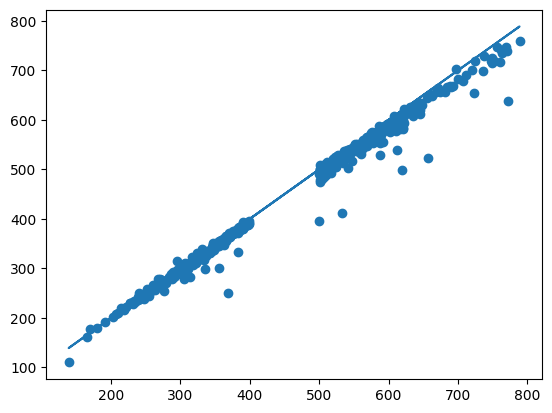

In [40]:
chemprop_pred_le_400 = run_chemprop(
    pd.read_csv("train_mw_lt_400.csv"), 
    pd.read_csv("test_mw_lt_400.csv"), 
    "mw", num_epochs=20, 
    aggregation="norm", 
    atom_featurizer=no_mw_atom_featurizer
)
chemprop_pred_gt_500 = run_chemprop(
    pd.read_csv("train_mw_lt_400.csv"), 
    pd.read_csv("test_mw_gt_500.csv"), 
    "mw", 
    num_epochs=20, 
    aggregation="norm",
    atom_featurizer=no_mw_atom_featurizer
)
plt.scatter(np.concatenate([test_ys, test_ys_out]), np.concatenate([chemprop_pred_le_400, chemprop_pred_gt_500]))
plt.plot(np.concatenate([test_ys, test_ys_out]), np.concatenate([test_ys, test_ys_out]))

## 40 epochs, no atomic mass

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

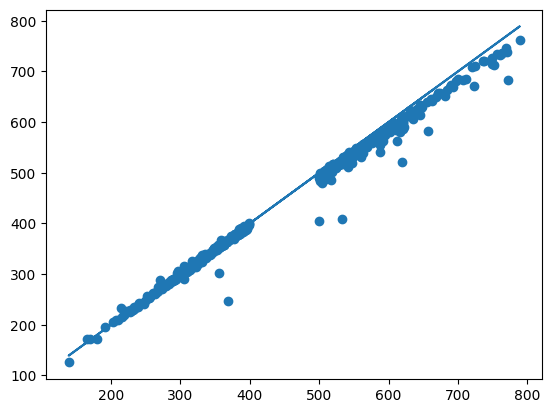

In [42]:
chemprop_pred_le_400 = run_chemprop(
    pd.read_csv("train_mw_lt_400.csv"), 
    pd.read_csv("test_mw_lt_400.csv"), 
    "mw", num_epochs=40, 
    aggregation="norm", 
    atom_featurizer=no_mw_atom_featurizer
)
chemprop_pred_gt_500 = run_chemprop(
    pd.read_csv("train_mw_lt_400.csv"), 
    pd.read_csv("test_mw_gt_500.csv"), 
    "mw", 
    num_epochs=40, 
    aggregation="norm",
    atom_featurizer=no_mw_atom_featurizer
)
plt.scatter(np.concatenate([test_ys, test_ys_out]), np.concatenate([chemprop_pred_le_400, chemprop_pred_gt_500]))
plt.plot(np.concatenate([test_ys, test_ys_out]), np.concatenate([test_ys, test_ys_out]))

## Taking out atomic mass and atomic number

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

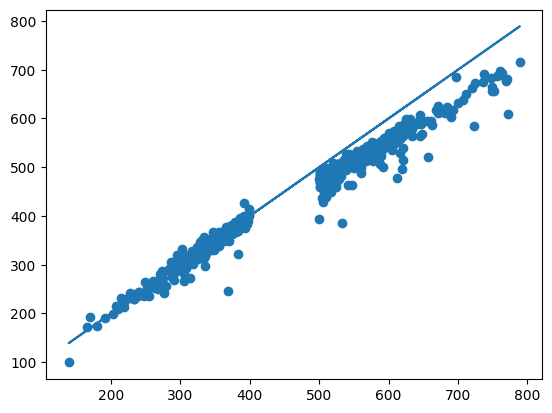

In [38]:
chemprop_pred_le_400 = run_chemprop(
    pd.read_csv("train_mw_lt_400.csv"), 
    pd.read_csv("test_mw_lt_400.csv"), 
    "mw", num_epochs=20, 
    aggregation="norm", 
    atom_featurizer=no_mw_no_an_atom_featurizer
)
chemprop_pred_gt_500 = run_chemprop(
    pd.read_csv("train_mw_lt_400.csv"), 
    pd.read_csv("test_mw_gt_500.csv"), 
    "mw", 
    num_epochs=20, 
    aggregation="norm",
    atom_featurizer=no_mw_no_an_atom_featurizer
)
plt.scatter(np.concatenate([test_ys, test_ys_out]), np.concatenate([chemprop_pred_le_400, chemprop_pred_gt_500]))
plt.plot(np.concatenate([test_ys, test_ys_out]), np.concatenate([test_ys, test_ys_out]))

## 40 epochs, no atomic mass, no atomic number

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

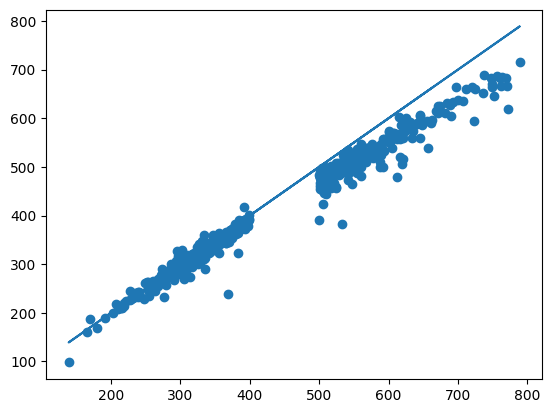

In [44]:
chemprop_pred_le_400 = run_chemprop(
    pd.read_csv("train_mw_lt_400.csv"), 
    pd.read_csv("test_mw_lt_400.csv"), 
    "mw", num_epochs=40, 
    aggregation="norm", 
    atom_featurizer=no_mw_no_an_atom_featurizer
)
chemprop_pred_gt_500 = run_chemprop(
    pd.read_csv("train_mw_lt_400.csv"), 
    pd.read_csv("test_mw_gt_500.csv"), 
    "mw", 
    num_epochs=40, 
    aggregation="norm",
    atom_featurizer=no_mw_no_an_atom_featurizer
)
plt.scatter(np.concatenate([test_ys, test_ys_out]), np.concatenate([chemprop_pred_le_400, chemprop_pred_gt_500]))
plt.plot(np.concatenate([test_ys, test_ys_out]), np.concatenate([test_ys, test_ys_out]))